In [1]:
import torch

import torch.nn as nn 
from torchvision import datasets, transforms, models

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import io
import requests
import time

In [2]:
device = "cpu" 

images used:

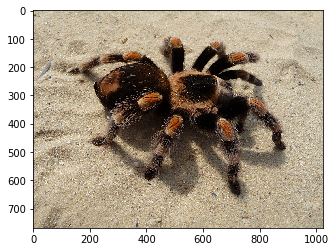

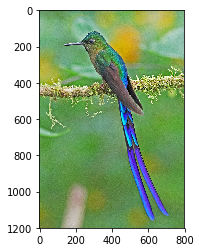

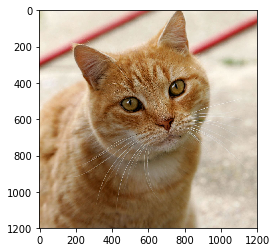

In [3]:
image_urls = ["https://upload.wikimedia.org/wikipedia/commons/thumb/9/98/Brachypelma_smithi_2009_G03.jpg/1024px-Brachypelma_smithi_2009_G03.jpg",
          "https://upload.wikimedia.org/wikipedia/commons/thumb/b/ba/Violet-tailed_Sylph_2_JCB.jpg/800px-Violet-tailed_Sylph_2_JCB.jpg",
         "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg"]

for url in image_urls:
    r = requests.get(url)
    pil_im = Image.open(io.BytesIO(r.content))
    im_array = np.asarray(pil_im)
    plt.imshow(im_array)
    plt.show()


attacks

In [4]:
def __fgsm(model, x, label, epsilon, targeted, clamp):
    model.zero_grad()

    x = torch.as_tensor(x, device=device)
    x.requires_grad = True
    
    logits = model(x)
    target = torch.LongTensor([label]).to(device)
    loss = nn.CrossEntropyLoss()(logits, target)
    loss.backward()
    
    diff = epsilon * x.grad.sign()
    
    if targeted:
        adv = x - diff
    else:
        adv = x + diff
    
    return adv.clamp(0, 1) if clamp else adv

def fgsm_targeted(model, x, label, epsilon, clamp=True):
    """
    model = neural network with logits output (not softmax)
    x = image 
    label = target label (don't care about the true label)
    epsilon = distance to move 
    clamp = Limit output values to the range [0,1]
    """
    return __fgsm(model, x, label, epsilon, True, clamp)
    
def fgsm_untargeted(model, x, label, epsilon, clamp=True):    
    """
    model = neural network with logits output (not softmax)
    x = image
    label = the true label
    epsilon = distance to move 
    clamp = Limit output values to the range [0,1]
    """
    return __fgsm(model, x, label, epsilon, False, clamp)

In [5]:
def __pgd(model, x, label, k, epsilon, epsilon_step, targeted, clamp):
    x = torch.as_tensor(x, device=device)
    
    x_min = x - epsilon
    x_max = x + epsilon
    
    for i in range(k):
        x = __fgsm(model, x.detach(), label, epsilon_step, targeted, clamp)  
        x = torch.max(x_min, x)
        x = torch.min(x_max, x)
    
    return x

def pgd_targeted(model, x, target, k, epsilon, epsilon_step, clamp=False):
    """
    model = neural network (with logits as output - not probs)
    x = image
    label = target
    k = number of iterations 
    epsilon = maximum allowed distance between input and output in infinity norm
    epsilon_step = distance in infinity norm moved each iteration
    clamp = bool; limit output channels to the interval [0,1]
    """
    return __pgd(model, x, target, k, epsilon, epsilon_step, True, clamp)

def pgd_untargeted(model, x, label, k, epsilon, epsilon_step, clamp=False):
    """
    model = neural network (with logits as output - not probs)
    x = image
    label = true label
    k = number of iterations 
    epsilon = maximum allowed distance between input and output in infinity norm
    epsilon_step = distance in infinity norm moved each iteration
    clamp = bool; limit output channels to the interval [0,1]
    """
    return __pgd(model, x, label, k, epsilon, epsilon_step, False, clamp)


In [6]:
model = models.resnet50(pretrained=True)
full_model = nn.Sequential(model, nn.Softmax(dim=1)).to(device).eval()

In [7]:
def plotter(image, adverserial, full_model):
    """Show the original (img), adversarial attack (adv), and some more stuff. Pass images as pytorch tensors"""
    image = image.cpu().detach()
    adverserial = adverserial.cpu().detach()
    
    probability_original = full_model(image.to(device)).cpu().detach().numpy()
    origial_image = image.numpy()[0]
    
    probability_adverserial = full_model(adverserial.to(device)).cpu().detach().numpy()
    adverserial_image = adverserial.numpy()[0]
    
    f, axes = plt.subplots(1,3, figsize=(15, 6))
    
    ax = axes[0]
    prediction = probability_original.argmax()
    ax.set_title("Original, class: {} ({:.0f} %): '{}'".format(
        prediction, 100*probability_original[0, prediction], labels[prediction])
    )
    ax.imshow(np.transpose(origial_image, (1,2,0)))
    
    ax = axes[1]
    prediction = probability_adverserial.argmax()
    ax.set_title("Adverserial, class: {} ({:.0f} %): '{}'".format(
        prediction, 100*probability_adverserial[0, prediction], labels[prediction])
    )
    ax.imshow(np.transpose(adverserial_image, (1,2,0)))
    
    ax = axes[2]
    diff = np.transpose(adverserial_image - origial_image, (1,2,0))
    plt.imshow(diff + 0.5)
    plt.show()

In [8]:
# URL for ImageNet labels in JSON
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json' 

originals=[]


for url in image_urls:
    IMG_URL = url
    
    # make request to static image file
    response = requests.get(IMG_URL)
    img = Image.open(io.BytesIO(response.content))  

    response = requests.get(LABELS_URL) 
    # parse labels into lookup
    labels = {int(key): value for key, value in response.json().items()}
    
    min_img_size = 224

    pre_transform = transforms.Compose([
        transforms.Resize(min_img_size),
        #transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #transforms.RandomRotation(32)
    ])

    img = pre_transform(img)
    original = transforms.ToTensor()(img).to(device)[None,] # [None,] iom att pytorch vill ha [batch x img]

    originals.append(original)

In [9]:
def predict(net, image, list_len=5, labels=labels):
    prediction = net(image)
    
    top_probs, top_labels = torch.topk(prediction, k=list_len, dim=1)
    
    max_len = max([len(labels[top_labels[0][i].item()]) for i in range(list_len)])
    base = "P[ {: <" + str(max_len) + "} ] = {:.3f}"
    for i in range(list_len):
        formatted = base.format(labels[top_labels[0][i].item()], top_probs[0][i].item()) 
        if i == 0:
            formatted = '\033[1m{}\033[0m'.format(formatted) 
        print(formatted)

Testing the attacks on resnet on the same 3 images 

P[ tarantula                   ] = 0.949
P[ fiddler crab                ] = 0.006
P[ tick                        ] = 0.006
P[ wolf spider, hunting spider ] = 0.005
P[ hermit crab                 ] = 0.004
This took 1.0s


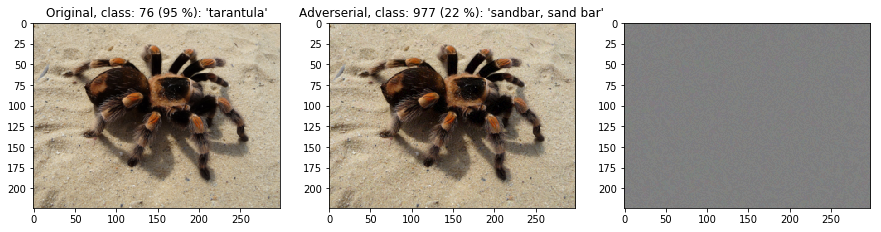

P[ hummingbird                             ] = 0.568
P[ jacamar                                 ] = 0.212
P[ bee eater                               ] = 0.152
P[ European gallinule, Porphyrio porphyrio ] = 0.018
P[ coucal                                  ] = 0.005
This took 1.0s


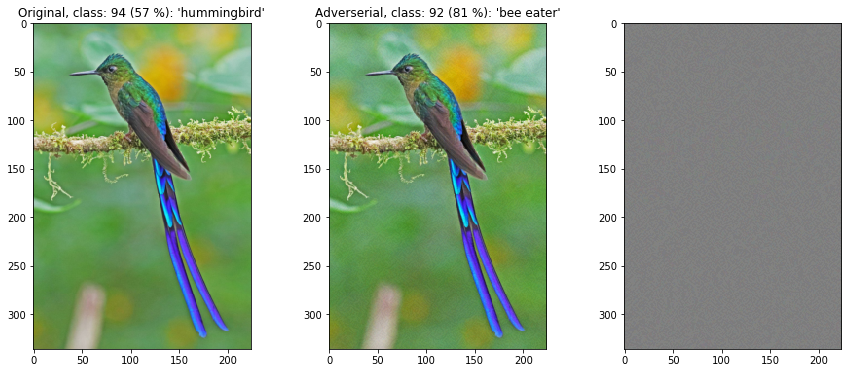

P[ Egyptian cat     ] = 0.331
P[ tiger cat        ] = 0.305
P[ tabby, tabby cat ] = 0.134
P[ plastic bag      ] = 0.058
P[ carton           ] = 0.016
This took 0.7s


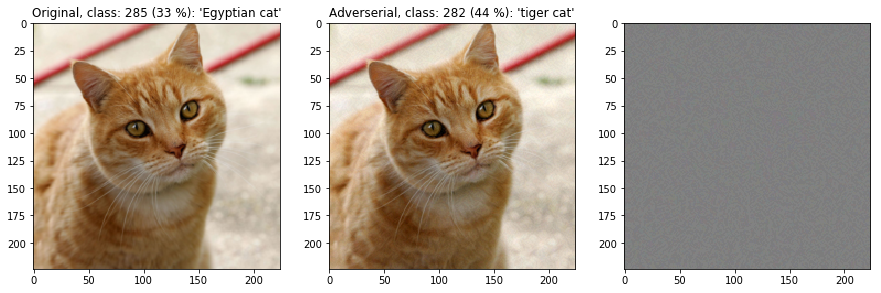

In [10]:
#fgsm untargeted 
for i in originals: 
    original=i
    predict(full_model, original)
    original_class = model(original).detach().cpu().numpy().argmax()
    original_class, labels[original_class]
    t = time.time()

    adv = fgsm_untargeted(model, original, label=original_class, epsilon=0.01, clamp=True)

    print("This took {:.1f}s".format(time.time() - t))
    plotter(original, adv, full_model)

P[ tarantula                   ] = 0.949
P[ fiddler crab                ] = 0.006
P[ tick                        ] = 0.006
P[ wolf spider, hunting spider ] = 0.005
P[ hermit crab                 ] = 0.004
This took 9.5s


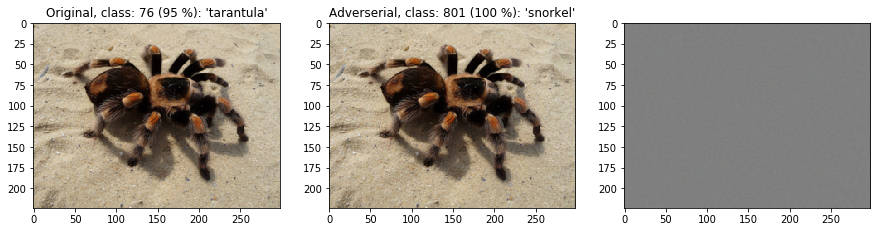

P[ hummingbird                             ] = 0.568
P[ jacamar                                 ] = 0.212
P[ bee eater                               ] = 0.152
P[ European gallinule, Porphyrio porphyrio ] = 0.018
P[ coucal                                  ] = 0.005
This took 10.0s


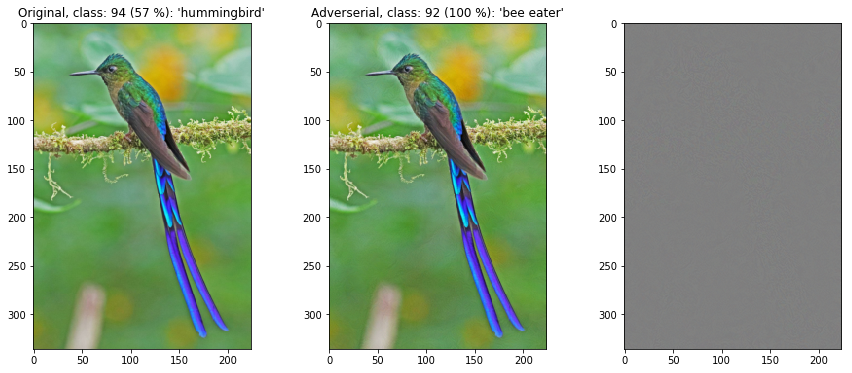

P[ Egyptian cat     ] = 0.331
P[ tiger cat        ] = 0.305
P[ tabby, tabby cat ] = 0.134
P[ plastic bag      ] = 0.058
P[ carton           ] = 0.016
This took 9.1s


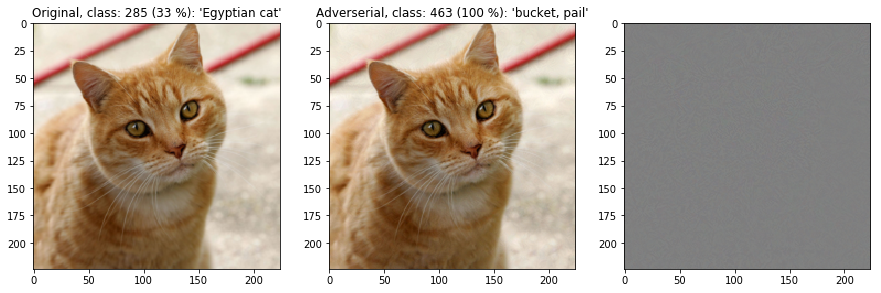

In [17]:
#pgd untargeted 
for i in originals: 
    original=i
    predict(full_model, original)
    original_class = model(original).detach().cpu().numpy().argmax()
    original_class, labels[original_class]
    t = time.time()

    adv = pgd_untargeted(model, original, label=original_class, k=10, epsilon=0.01, epsilon_step=0.001, clamp=True)

    print("This took {:.1f}s".format(time.time() - t))
    plotter(original, adv, full_model)

## Targeted

In [12]:
target = 79
target, labels[target]

(79, 'centipede')

### FGSM targeted

This took 1.0s


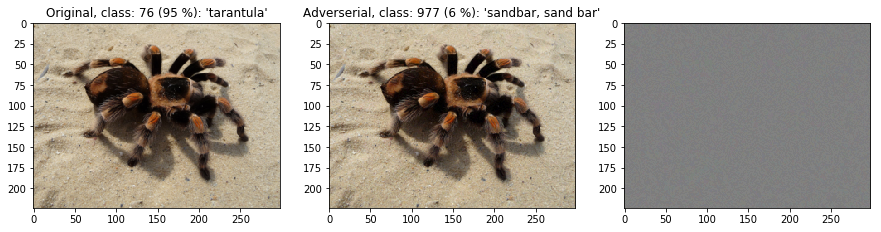

This took 1.0s


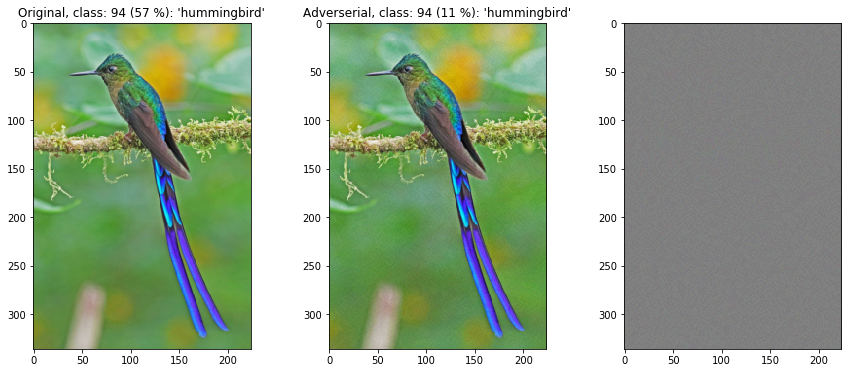

This took 0.7s


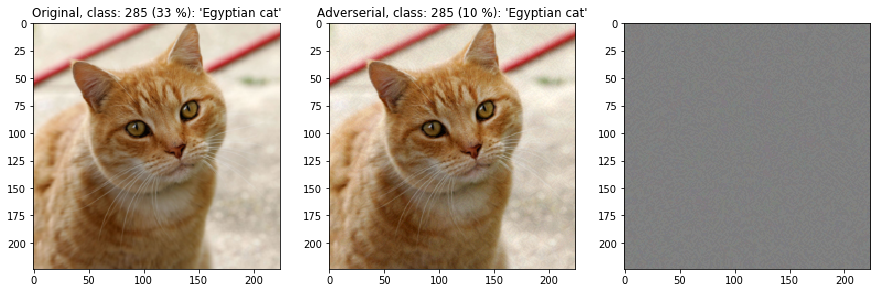

In [19]:
for i in originals: 
    original=i
    
    t = time.time()

    adv = fgsm_targeted(model, original, label=target, epsilon=0.01)

    print("This took {:.1f}s".format(time.time() - t))
    plotter(original, adv, full_model)

### PGD-targeted

This took 9.3s


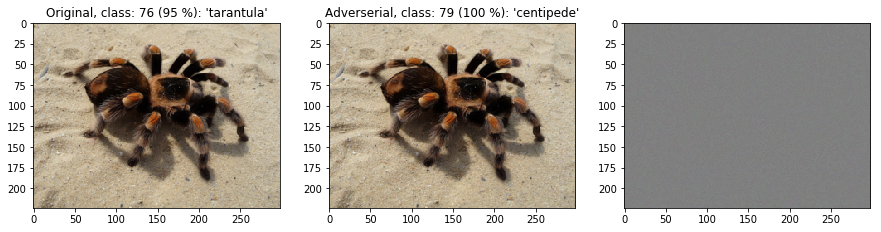

This took 9.9s


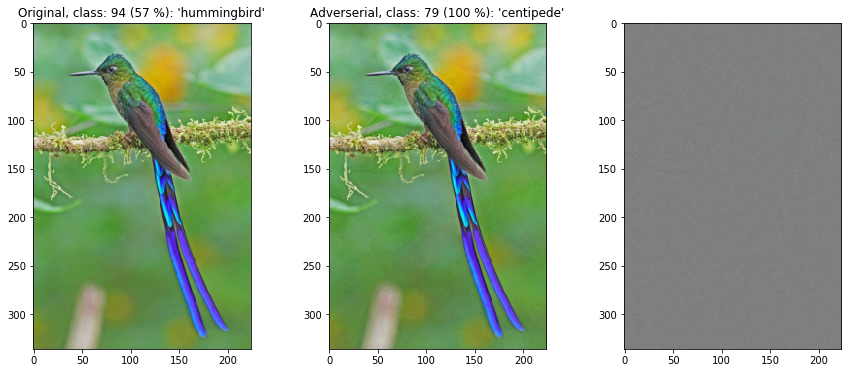

This took 7.7s


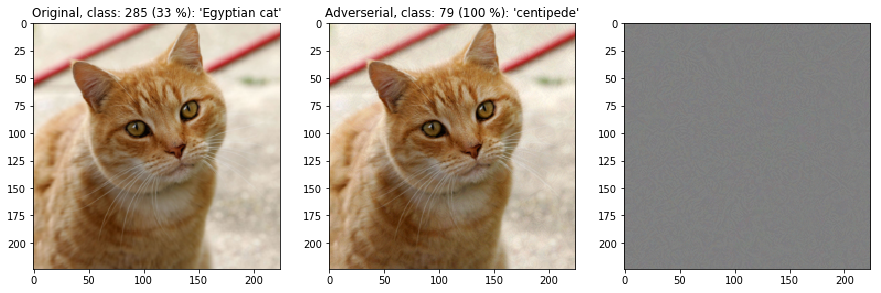

In [14]:
for i in originals: 
    original=i
    t = time.time()

    adv = pgd_targeted(model, original, target=target, k=10, epsilon=0.01, epsilon_step=0.005, clamp=True)

    print("This took {:.1f}s".format(time.time() - t))
    plotter(original, adv, full_model)

## pgd-Targeting the least probable class

798 slide rule, slipstick 9.09e-06 %
This took 9.4s


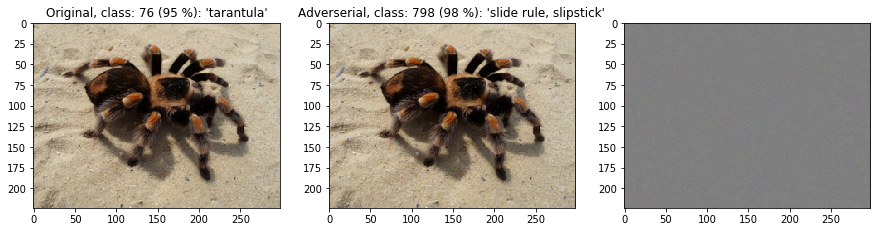

661 Model T 3.34e-06 %
This took 10.8s


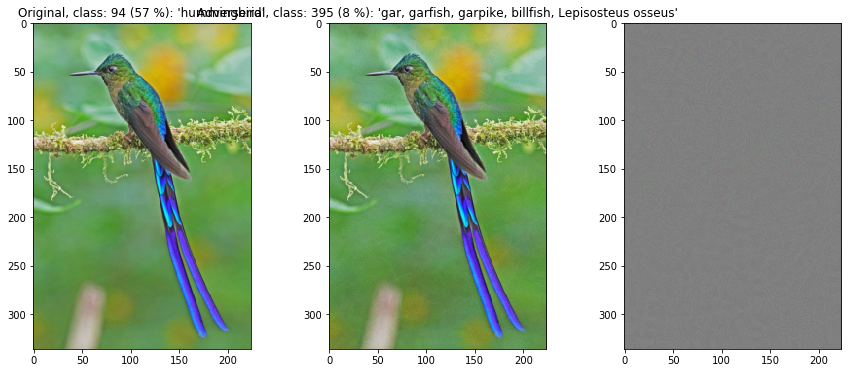

609 jeep, landrover 5.09e-06 %
This took 7.6s


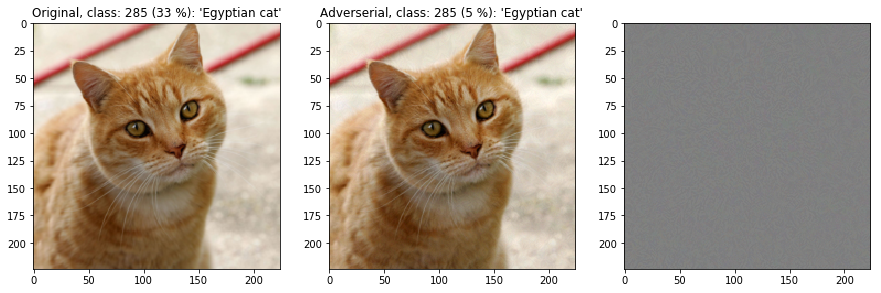

In [15]:
for i in originals: 
    original=i
    predictions = full_model(original).detach().cpu().numpy()
    least_probale = predictions.argmin()
    target = least_probale
    print(target, labels[target], "{:.2e} %".format(100*predictions[0, least_probale]))
    
    
    t = time.time()

    adv = pgd_targeted(model, original, target=target, k=10, epsilon=0.01, epsilon_step=0.005, clamp=True)

    print("This took {:.1f}s".format(time.time() - t))
    plotter(original, adv, full_model)

for tarantula epsilon 0.01 is enough
but not for the hummingbird and cat

798 slide rule, slipstick 9.09e-06 %
This took 9.7s


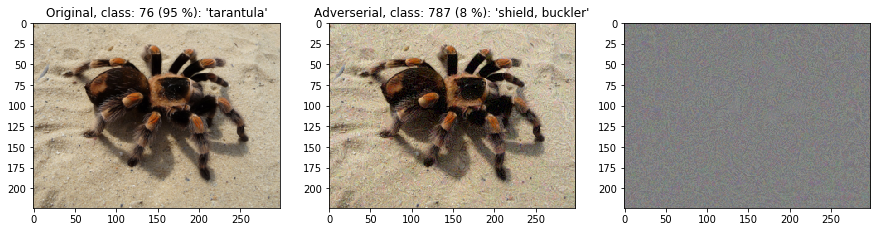

661 Model T 3.34e-06 %
This took 12.4s


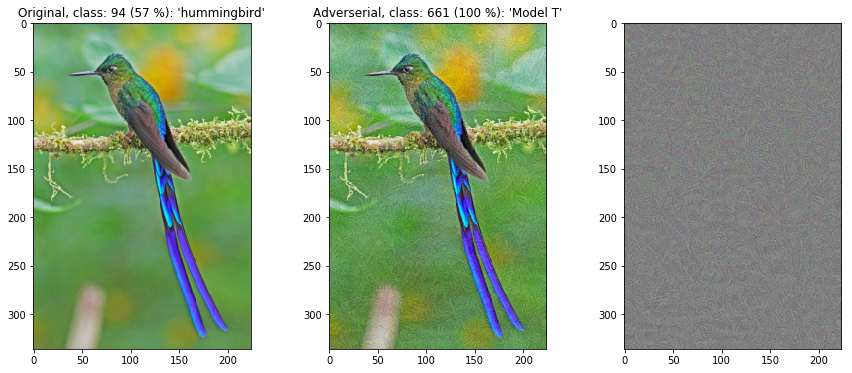

609 jeep, landrover 5.09e-06 %
This took 8.0s


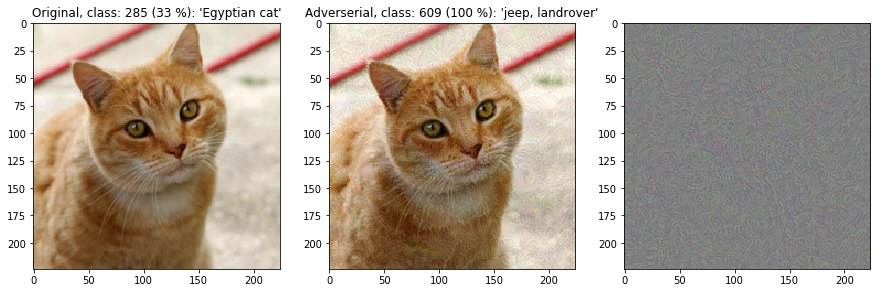

In [16]:
for i in originals: 
    original=i
    predictions = full_model(original).detach().cpu().numpy()
    least_probale = predictions.argmin()
    target = least_probale
    print(target, labels[target], "{:.2e} %".format(100*predictions[0, least_probale]))
    


    t = time.time()

    adv = pgd_targeted(model, original, target=target, k=10, epsilon=0.05, epsilon_step=0.01, clamp=True)

    print("This took {:.1f}s".format(time.time() - t))
    plotter(original, adv, full_model)